## import libraries

In [1]:
import torch
import numpy as np
from torch.autograd import Variable
import random
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

## dataset

In [2]:
nnnn = 8000
tnnnn = 2000
s = np.random.uniform(-10,10,(nnnn,2))
labels = np.array([0]*nnnn )
for i in range(nnnn):
    if s[i][1]>s[i][0]:
        if s[i][1]>-0.2*s[i][0] and s[i][1]<-0.65*s[i][0]+1:
            labels[i]=1  
        else:
            labels[i]=0  
        
    else:
        if s[i][1]<-0.2*s[i][0] and s[i][1]>-0.65*s[i][0]+1 and s[i][0]>3.4:
            labels[i]=0
        else:
            labels[i]=1
        

feature_set = s
feature_set, labels = shuffle(np.array(feature_set), np.array(labels))

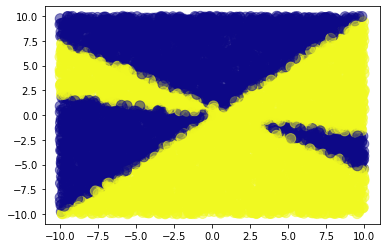

In [3]:
plt.figure()
plt.scatter(feature_set[:,0], feature_set[:,1], c=labels, cmap='plasma', s=100, alpha=0.5)
plt.show()

## define environment

In [4]:
class SimpleDataEnv():
    def __init__(self, images_per_episode=1, dataset=(feature_set[:nnnn-tnnnn], labels[:nnnn-tnnnn]), random=True):
        self.images_per_episode = images_per_episode
        self.step_count = 0
        self.x, self.y = dataset
        self.random = random
        self.dataset_idx = 0

    def step(self, action):
        done = False
        if action == self.expected_action:
            reward = 1
        else:
            reward = -3

        obs = self._next_obs()
        self.step_count += 1
        if self.step_count >= self.images_per_episode:
            done = True

        return obs, reward, done, self.expected_action

    def reset(self):
        self.step_count = 0
        obs = self._next_obs()
        return obs

    def _next_obs(self):
        if self.random:
            next_obs_idx = random.randint(0, len(self.x) - 1)
            self.expected_action = int(self.y[next_obs_idx])
            obs = self.x[next_obs_idx]

        else:
            obs = self.x[self.dataset_idx]
            self.expected_action = int(self.y[self.dataset_idx])

            self.dataset_idx += 1
            if self.dataset_idx >= len(self.x):
                raise StopIteration()

        return obs


In [5]:
env = SimpleDataEnv(images_per_episode=10)

## define DQN agent

In [6]:
class DQN():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.05):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(n_state, n_hidden),
                        torch.nn.ReLU(),
                        torch.nn.Linear(n_hidden, n_action)
                )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)


    def update(self, s, y):
        y_pred = self.model(torch.Tensor(s))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_feature(self, s):
        features = torch.tensor(s).float()
        return features

    def predict(self, s):
        features = self.get_feature(s)
        with torch.no_grad():
            return self.model(torch.Tensor(features))


## action selection with epsilon greedy policy

In [7]:
def gen_epsilon_greedy_policy(estimator, epsilon, n_action):
    def policy_function(state):
        if random.random() < epsilon:
            return random.randint(0, n_action - 1)
        else:
            q_values = estimator.predict(state)
            return torch.argmax(q_values).item()
    return policy_function


In [8]:
def featureNormalization(X):
    std = X.std()
    mean = X.mean()
    X_norm = (X - X.mean()) / X.std()
    return X_norm , mean , std


## Q-learnig

In [9]:
def q_learning(env, estimator, n_episode, gamma=1.0, epsilon=0.1, epsilon_decay=.99): 
    for episode in range(n_episode):
        policy = gen_epsilon_greedy_policy(estimator, epsilon, n_action)
        state = env.reset()
        is_done = False

        while not is_done:
            action = policy(state)
            next_state, reward, is_done, _ = env.step(action)
            total_reward_episode[episode] += reward
            q_values = estimator.predict(state).tolist()

            if is_done:
                q_values[action] = reward
                estimator.update(state, q_values)
                break

            q_values_next = estimator.predict(next_state)
            q_values[action] = reward + gamma * torch.max(q_values_next).item()
            estimator.update(state, q_values)

            state = next_state
        if episode % 1000 == 0:
          print('Episode: {}, AVG reward: {}, epsilon: {}'.format(episode, sum(total_reward_episode[episode-1000:episode])/1000, epsilon))

        epsilon = max(epsilon * epsilon_decay, 0.01)


In [10]:
n_state = 2
n_action = 2
n_hidden = 10
lr = 0.001
dqn = DQN(n_state, n_action, n_hidden, lr)

In [11]:
n_episode = 100000
total_reward_episode = [0] * n_episode
q_learning(env, dqn, n_episode, gamma=.9, epsilon=.3)

Episode: 0, AVG reward: 0.0, epsilon: 0.3
Episode: 1000, AVG reward: 3.324, epsilon: 0.01
Episode: 2000, AVG reward: 4.108, epsilon: 0.01
Episode: 3000, AVG reward: 4.28, epsilon: 0.01
Episode: 4000, AVG reward: 4.152, epsilon: 0.01
Episode: 5000, AVG reward: 4.356, epsilon: 0.01
Episode: 6000, AVG reward: 4.22, epsilon: 0.01
Episode: 7000, AVG reward: 4.052, epsilon: 0.01
Episode: 8000, AVG reward: 4.112, epsilon: 0.01
Episode: 9000, AVG reward: 4.316, epsilon: 0.01
Episode: 10000, AVG reward: 4.372, epsilon: 0.01
Episode: 11000, AVG reward: 4.16, epsilon: 0.01
Episode: 12000, AVG reward: 4.032, epsilon: 0.01
Episode: 13000, AVG reward: 4.216, epsilon: 0.01
Episode: 14000, AVG reward: 4.172, epsilon: 0.01
Episode: 15000, AVG reward: 4.136, epsilon: 0.01
Episode: 16000, AVG reward: 4.224, epsilon: 0.01
Episode: 17000, AVG reward: 4.176, epsilon: 0.01
Episode: 18000, AVG reward: 4.42, epsilon: 0.01
Episode: 19000, AVG reward: 3.976, epsilon: 0.01
Episode: 20000, AVG reward: 4.324, epsil

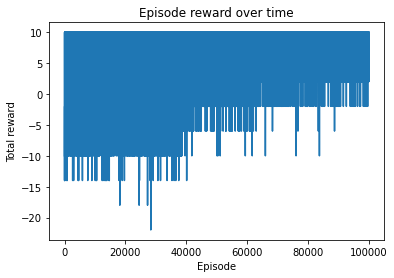

In [12]:
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

## evalute with test

In [13]:
counter = 0
fault = 0
policy = gen_epsilon_greedy_policy(dqn, 0.01, 2)
for n in range(nnnn-tnnnn,nnnn):
  action = policy(feature_set[n])
  if action == labels[n]:
    counter = counter + 1
  else:
    fault = fault + 1
print("correct classification: ",counter)
print("incorrect classification: ",fault)
print(counter/(counter+fault))

correct classification:  1975
incorrect classification:  25
0.9875
